## Support Vector Machine

In [2]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import svm, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from nose.tools import assert_equal, assert_in, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

sns.set(style="white")

In [3]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(5, 8, 15, 16, 18))

In [4]:
local = df[(df['Origin'] == 'ORD') & (df['UniqueCarrier'] == 'AA')]
local = local.drop(['UniqueCarrier', 'Origin'], axis=1) 
local['Delayed'] = (local['DepDelay'] > 0).astype(np.int) 
local = local.drop('DepDelay', axis=1).dropna() 

In [6]:
print('Delayed: {}\nNot delayed: {}'.format(
    (local.Delayed == 0).sum(),
    (local.Delayed == 1).sum()
    ))

Delayed: 61932
Not delayed: 44006


In [6]:
print(local.head(5))

        CRSDepTime  Distance  Delayed
398444        1905      1846        1
398445        1905      1846        1
398446        1905      1846        1
398447        1905      1846        0
398448        1905      1846        1


### Split

In [5]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of numpy.ndarrays
    '''
    
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    X_train=np.array(X_train)
    X_test=np.array(X_test)
    y_train=np.array(y_train).flatten()
    y_test=np.array(y_test).flatten()
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.4,
    random_state=check_random_state(0)
    )

In [7]:
n_samples_train, n_features_train = X_train.shape
n_samples_test, n_features_test = X_test.shape

assert_equal(n_features_train, 2)
assert_equal(n_features_test, 2)
n_features = n_features_train

assert_equal(np.abs(n_samples_train - np.round(len(local) * 0.6)) <= 1, True)
assert_equal(np.abs(n_samples_test - np.round(len(local) * 0.4)) <= 1, True)

assert_array_equal(X_train[:5],
    np.array(
        [[ 1500.,  1846.],
         [ 1415.,   802.],
         [ 1138.,   409.],
         [ 1649.,   723.],
         [ 1835.,   678.]]
        ))
assert_array_equal(X_test[:5],
    np.array(
        [[  645.,  1745.],
         [  620.,   622.],
         [  645.,  1745.],
         [ 2040.,   678.],
         [  835.,   268.]]
        ))

assert_array_equal(y_train[:10], np.array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1]))
assert_array_equal(y_test[:10], np.array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1]))


### Scale

In [29]:
def standardize(df):
    '''
    Takes a dataframe and normlizes features to be in range [0, 1].
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame
    '''
    
    df_std =(df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    scaled = df_std * 2 -1
    return scaled

In [30]:
df0 = pd.DataFrame({
    'a': [0, 1, 2, 3, 4],
    'b': [-50, -20, 10, 45, 50],
    'c': [-200, 450, 100, 500, -500]
    })
test1 = standardize(df0)
answer1 = pd.DataFrame({
        'a': [ -1., -0.5, 0., 0.5, 1.],
        'b': [ -1., -0.4, 0.2, 0.9, 1.],
        'c': [ -0.4, 0.9, 0.2, 1., -1.]
    })
assert_frame_equal(test1, answer1)

In [31]:
X_train_scaled, X_test_scaled = map(standardize, [X_train, X_test])

### Train SVM

In [33]:
def fit_and_predict(X_train, y_train, X_test, kernel):
    '''
    Fits a Support Vector Machine on the training data on "X_train" and "y_train".
    Returns the predicted values on "X_test".
    
    Parameters
    ----------
    X_train: A numpy.ndarray
    y_train: A numpy.ndarray
    X_test: A numpy.ndarray
    kernel: A string that specifies kernel to be used in SVM
    
    Returns
    -------
    model: An svm.SVC instance trained on "X_train" and "y_train"
    y_pred: A numpy array. Values predicted by "model" on "X_test"
    '''
    
    svc = svm.SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred=svc.predict(X_test)
    return svc, y_pred

In [34]:
X_train_t = [[-2, -1], [-1, -1], [-1, -2], [1, 1], [1, 2], [2, 1]]
y_train_t = [1, 1, 1, 2, 2, 2]
X_test_t = [[-1, -1], [2, 2], [3, 2]]
y_test_t = [1, 2, 2]

model1, pred1 = fit_and_predict(X_train_t, y_train_t, X_test_t, 'linear')
assert_equal(isinstance(model1, svm.SVC), True)
assert_equal(model1.kernel, 'linear')
assert_array_equal(pred1, y_test_t)

model2, pred2 = fit_and_predict(X_train_t, y_train_t, X_test_t, 'rbf')
assert_equal(model2.kernel, 'rbf')
assert_array_equal(pred2, y_test_t)

In [35]:
clf, y_pred = fit_and_predict(X_train_scaled, y_train, X_test_scaled, 'rbf')

In [36]:
print(accuracy_score(y_test, y_pred))

0.593779497829


### Confusion matrix

In [37]:
def plot_confusion():
    '''
    Plots a confusion matrix using numpy.histogram2d() and seaborn.heatmap().
    Returns a maptlotlib.axes.Axes instance.
    '''
    
    fig, ax = plt.subplots()
    names = ['Not delayed', 'Delayed']
    pts, xe, ye = np.histogram2d(np.array(y_test).flatten(), np.array(y_pred).flatten(), bins=2)
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title('Confusion matrix for SVM')
    return ax

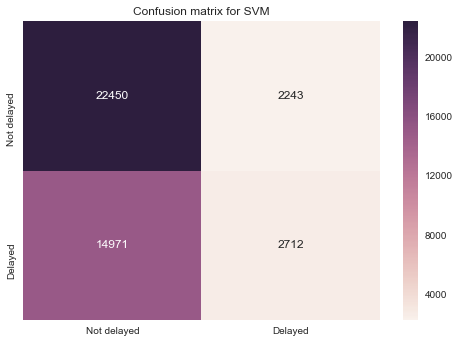

In [39]:
ax=plot_confusion()

In [40]:
assert_equal(isinstance(ax, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

texts = [t.get_text() for t in ax.texts]
assert_equal(texts, ['14971', '2712', '22450', '2243'])
             
x_tick_labels = [l.get_text() for l in ax.get_xticklabels()]
y_tick_labels = [l.get_text() for l in ax.get_yticklabels()]
assert_equal(y_tick_labels, ['Delayed', 'Not delayed'])

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")